In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Rescaling, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import KLDivergence
from sklearn.model_selection import GroupKFold
import tensorflow.keras.backend as K

Mounted at /content/drive


In [ ]:
VER = 1
LOAD_MODELS_FROM = '/content/drive/MyDrive/kaggle/models/v0/'

When training deep learning models, computations are typically done using 32-bit floating point numbers (FP32). However, 16-bit floating point numbers (FP16) can be used instead for certain parts of the computation without sacrificing much accuracy. This is because FP16 consumes less memory and allows for faster calculations, especially on hardware like GPUs that are optimized for this type of arithmetic.

Enabling automatic mixed precision means that TensorFlow will analyze the computations in your model and, whenever possible, perform them using FP16 instead of FP32. This can lead to significant speedups in training time and reduced memory usage, particularly on hardware that supports FP16 acceleration, such as modern GPUs with Tensor Cores.

In [ ]:
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    print('Mixed precision enabled')
else:
    print('Using full precision')

Mixed precision enabled


In [ ]:
def process_train_data(df):

  TARGETS = df.columns[-6:]

  train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
      {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
  train.columns = ['spec_id','min']

  tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
      {'spectrogram_label_offset_seconds':'max'})
  train['max'] = tmp

  tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
  train['patient_id'] = tmp

  tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
  for t in TARGETS:
      train[t] = tmp[t].values

  y_data = train[TARGETS].values
  y_data = y_data / y_data.sum(axis=1,keepdims=True)
  train[TARGETS] = y_data

  tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
  train['target'] = tmp

  train = train.reset_index()
  print('Train non-overlapp eeg_id shape:', train.shape )
  train.head()

  return train, y_data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/kaggle/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [ ]:
SPEC_PATH = '/content/drive/MyDrive/kaggle/specs.npy'
spectrograms = np.load(SPEC_PATH, allow_pickle=True).item()
train, y_data = process_train_data(df)
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, shuffle=False, mode='train',
                 specs = spectrograms):

        self.data = data
        self.batch_size = batch_size
        self.mode = mode
        self.specs = specs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'

        X = np.zeros((len(indexes),128,256,4),dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')
        img = np.ones((128,256),dtype='float32')

        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            if self.mode=='test':
                r = 0
            else:
                r = int( (row['min'] + row['max'])//4 )

            for k in range(4):
                img = self.specs[row.spec_id][r:r+300,k*100:(k+1)*100].T
                img = np.clip(img, np.exp(-4), np.exp(8))
                img = np.log(img)

                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img-m)/(s+ep)
                img = np.nan_to_num(img, nan=0.0)

                X[j,14:-14,:,k] = img[:,22:-22] # / 2.0

            if self.mode!='test':
                y[j,] = row[TARGETS]

        return X,y

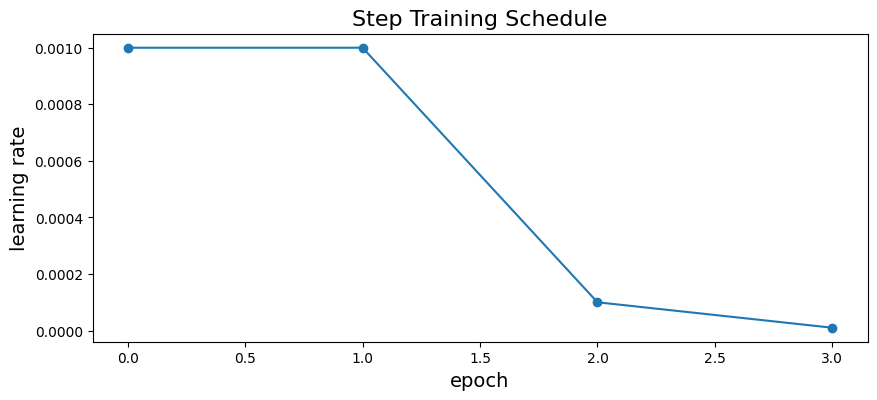

In [ ]:
def lrfn(epoch):
    if epoch < 1:
        lr = 1e-3
    else:
        lr = 1e-3 * 0.1**((epoch - 1))
    return lr

rng = [i for i in range(4)]
y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, y, 'o-');
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Step Training Schedule',size=16); plt.show()

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [ ]:
! pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
import efficientnet.tfkeras as efn

def build_model():

    inp = tf.keras.Input(shape=(128,256,4))
    base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=None)

    x = [inp[:,:,:,i:i+1] for i in range(4)]
    x = tf.keras.layers.Concatenate(axis=1)(x)
    x = tf.keras.layers.Concatenate(axis=3)([x,x,x])

    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)

    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()

    model.compile(loss=loss, optimizer = opt)

    return model

In [ ]:
all_oof = []
all_true = []

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):

    print('#'*25)
    print(f'### Fold {i+1}')

    train_gen = DataGenerator(train.iloc[train_index], shuffle=True, batch_size=32)
    valid_gen = DataGenerator(train.iloc[valid_index], shuffle=False, batch_size=64, mode='valid')

    K.clear_session() # good practice to clear previous training sessions, helps allocate memory
    model = build_model()
    if LOAD_MODELS_FROM is None:
        model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=4, callbacks = [LR])
        model.save_weights(f'/content/drive/MyDrive/kaggle/models/v0/EffNet_v{VER}_f{i}.h5')
    else:
        model.load_weights(f'/content/drive/MyDrive/kaggle/models/v0/EffNet_v0_f{i}.h5')
        model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=4, callbacks = [LR])
        model.save_weights(f'/content/drive/MyDrive/kaggle/models/v1/EffNet_v{VER}_f{i}.h5')

    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(train.iloc[valid_index][TARGETS].values)

    del model, oof

all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/4
428/428 [==============================] - 211s 416ms/step - loss: 0.7176 - val_loss: 1.0946 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/4
428/428 [==============================] - 178s 415ms/step - loss: 0.6423 - val_loss: 1.0539 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/4
428/428 [==============================] - 178s 415ms/step - loss: 0.4967 - val_loss: 0.8787 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/4
54/54 [==============================] - 17s 283ms/step
#########################
### Fold 2

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/4
428/428 [==============================] - 213s 418ms/step - loss: 0.7181 - val_loss: 1.2356 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate 

In [ ]:
PATH2 = '/content/drive/MyDrive/kaggle/'
test = pd.read_csv(f'{PATH2}test.csv')
test.rename(columns={'spectrogram_id': 'spec_id'}, inplace=True)
test.head()

,spec_id,eeg_id,patient_id
0,853520,3911565283,6885


In [ ]:
test_spectrograms = {}
for index, row in test.iterrows():
  spec_id = row.spec_id
  spec_df = np.array(pd.read_parquet(f'{PATH2}{spec_id}.parquet').drop('time', axis=1))
  test_spectrograms[spec_id] = spec_df

In [ ]:
preds = []
model = build_model()
test_gen = DataGenerator(test, shuffle=False, batch_size=64, mode='test',
                         specs = test_spectrograms)
for i in range(5):
    print(f'Fold {i+1}')
    if LOAD_MODELS_FROM:
        model.load_weights(f'/content/drive/MyDrive/kaggle/models/v1/EffNet_v{VER}_f{i}.h5')
    else:
        model.load_weights(f'{PATH2}models/v0/EffNet_v{VER}_f{i}.h5')
    pred = model.predict(test_gen, verbose=1)
    preds.append(pred)
pred = np.mean(preds,axis=0)
print('\n')
print('Test preds shape',pred.shape)

Fold 1
1/1 [==============================] - 2s 2s/step
Fold 2
1/1 [==============================] - 0s 48ms/step
Fold 3
1/1 [==============================] - 0s 48ms/step
Fold 4
1/1 [==============================] - 0s 46ms/step
Fold 5
1/1 [==============================] - 0s 48ms/step


Test preds shape (1, 6)


In [ ]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submission shape',sub.shape)
sub.head()

Submission shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.041355,0.17321,0.001641,0.12272,0.017382,0.643692
